# Degradation Analysis
For Dirk Jordan
- Deployment: Solar Futures
- replacements in 2050: with 
   (i) 0.7 degradation as baseline, 
   (ii) 0.8 %/year degradation and 
   (iii) 0.95%/year

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'PVRW2023')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#0079C2','#00A4E4','#F7A11A','#5D9732','#933C06','#5E6A71'] # 
import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

scennames_labels = ['0.7%deg','0.8%deg','0.95%deg'] #

In [3]:
#gradient generator
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

color1 = '#0079C2'
color2 = '#F7A11A'


Scenarios and Materials

In [4]:
import PV_ICE

In [5]:
#creating scenarios
#scennames = ['0.7%deg','0.8%deg','0.95%deg']
MATERIALS = ['glass','silver','silicon', 'copper', 'aluminium_frames'] #'encapsulant', 'backsheet',
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [6]:
#bring in Solar Futures deployment

#in the Supporting Material Folder
reedsFile = str(Path().resolve().parent.parent/ 'PV_ICE' /'baselines'/'SupportingMaterial' /
                'December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx')
#print ("Input file is stored in %s" % reedsFile)

REEDSInput = pd.read_excel(reedsFile, sheet_name="new installs PV")
#NEED TO CHECK THAT AC to DC has been taken care of in excel file (there is a multiplier, is set to 1)

rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year'], inplace=True)

df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum()
df_reeds = pd.DataFrame(df)

reeds_proj = pd.DataFrame(df_reeds.unstack(level=1).iloc[1]) #this is the 95-by-35_Elec.Adv+DR scenario, is a series
reeds_proj_MW = reeds_proj*0.85*1000 #convert to MW and include AC to DC ratio
reeds_proj_simple = reeds_proj_MW.droplevel(level=0)

SFscenarios = ['95-by-35_Elec.Adv+DR'] #Decarb+E

In [7]:
reeds_proj_simple.loc[2020]

95-by-35+Elec.Adv+DR    16995.842998
Name: 2020, dtype: float64

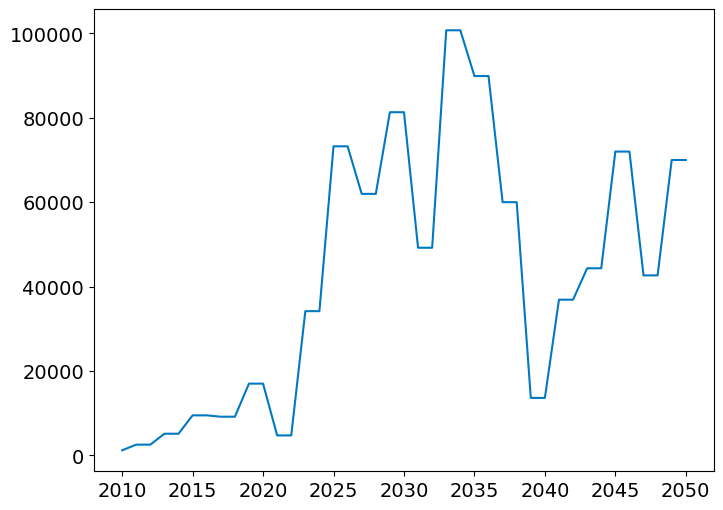

In [8]:
plt.plot(reeds_proj_simple)

# Explore Degradation
explore effect of the range of degradation rates as requested by Dirk Jordan

In [9]:
Degradation_Range = pd.Series([0.7, 0.8, 0.95])
#Degradation_Range

In [10]:
sim2 = PV_ICE.Simulation(name='sim1_deg', path=testfolder) #init simulation

for degs in range(0,len(Degradation_Range)):
        scenname = 'deg_' + str(Degradation_Range[degs])+'%/yr' #name the scenario
        sim2.createScenario(name=scenname, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e) #create the scenario with name
        for mat in range (0, len(MATERIALS)):
            matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
            matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
            sim2.scenario[scenname].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\PVRW2023


In [11]:
scennames2 = pd.Series(sim2.scenario.keys())
scennames2

0     deg_0.7%/yr
1     deg_0.8%/yr
2    deg_0.95%/yr
dtype: object

In [12]:
# Degradation

#Lifetime and Degradation
# use scenarios is none to set all
#Mod Project Lifetime
sim2.modifyScenario(scenarios=None, stage='mod_lifetime', value=200, start_year=2022) #
#T50
sim2.modifyScenario(scenarios=None, stage='mod_reliability_t50', value=250, start_year=2022)
#t90
sim2.modifyScenario(scenarios=None, stage='mod_reliability_t90', value=280, start_year=2022) 

In [13]:
#degradation rates:
#modify scenarios with dictionary of deg rates range from Jordan et al 2022

for scen in range(0,len(scennames2)):
    sim2.modifyScenario(scennames2[scen], 'mod_degradation', Degradation_Range[scen], start_year=2022) # Jordan et al 2022

In [14]:
sim2.scenario['deg_0.95%/yr'].dataIn_m.tail(2)

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled
54,2049,140186.0884,24.94841,250.0,280.0,0.95,200.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
55,2050,152662.6502,25.00164,250.0,280.0,0.95,200.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0


In [15]:
#deployment projection for all scenarios
sim2.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', 
                    value=reeds_proj_simple.loc[2020:,'95-by-35+Elec.Adv+DR'], start_year=2020) #

In [16]:
sim2.scenario['deg_0.95%/yr'].dataIn_m.tail(2)

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg1_landfill,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled
54,2049,69993.457237,24.94841,250.0,280.0,0.95,200.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0
55,2050,69993.457237,25.00164,250.0,280.0,0.95,200.0,98.0,0.0,0.0,...,60.0,0.0,0.0,40.0,0.0,100.0,60.0,0.0,0.0,40.0


In [17]:
#trim to start in 1995 and extend to 2100, this trims module and materials
#had to specify and end year, cannot use to extend
sim2.trim_Years(startYear=1995, endYear=2050)

Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Mass, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Mass, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, years now encompass  1995  to  2050
Data trimmed for Energy, yea

In [32]:
#create cumulative installs series for plotting later
idx_temp = pd.RangeIndex(start=1995,stop=2051,step=1) #create the index
installs_cumu = sim2.scenario['deg_0.95%/yr'].dataIn_m['new_Installed_Capacity_[MW]'].cumsum()
installs_cumu.index = idx_temp
#installs_cumu

In [19]:
sim2.calculateFlows(nameplatedeglimit=0.8) #remove at 80% of nameplate power

>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  deg_0.8%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Mater

In [20]:
sim2_ii_yearly, sim2_ii_cumu = sim2.aggregateResults() #have to do this to get auto plots
sim2_ii_allenergy, sim2_ii_energyGen, sim2_ii_energy_demands = sim2.aggregateEnergyResults()

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)


(0.0, 1838649.4790407976)

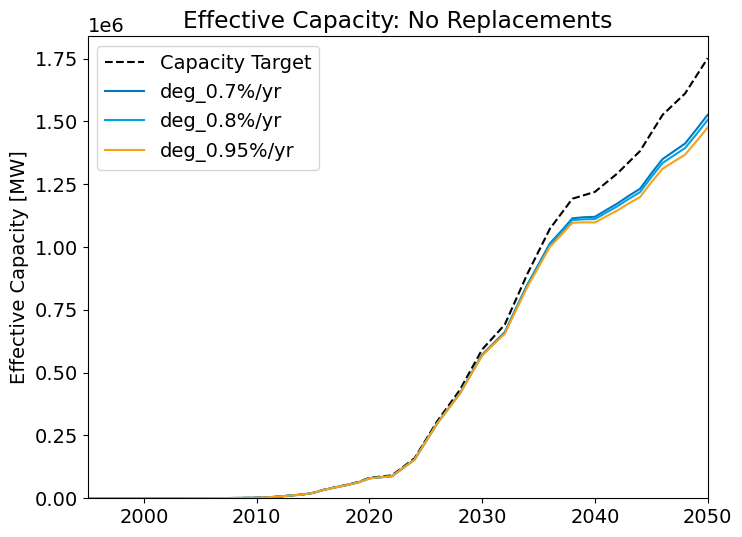

In [33]:
effective_capacity = sim2_ii_yearly.filter(like='ActiveCapacity')
plt.plot(installs_cumu, label='Capacity Target', color='black', ls='--')
    
plt.plot(effective_capacity, label=scennames2)
plt.legend()
plt.ylabel('Effective Capacity [MW]')
plt.title('Effective Capacity: No Replacements')
plt.xlim(1995,2050)
plt.ylim(0,)

(0.0, 1.8386494790407975)

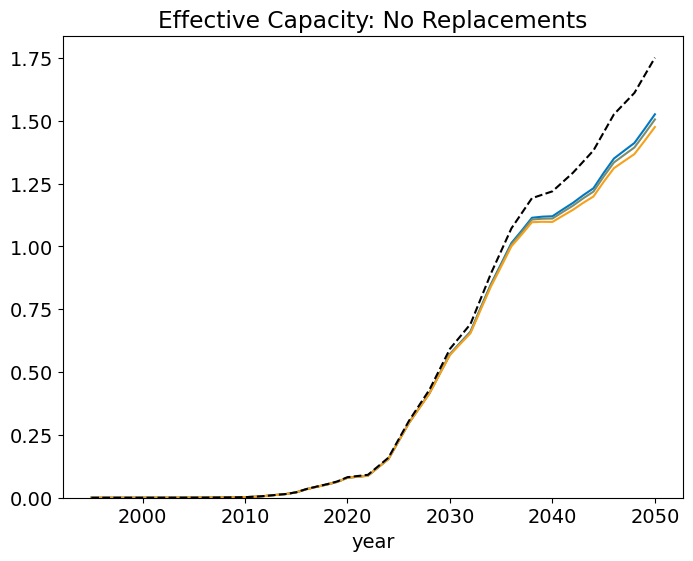

In [37]:
colors = get_color_gradient(color1, color2, len(scennames2)) #generates a list of hex values
effective_capacity_tw = effective_capacity/1e6
effective_capacity_tw.plot(color=colors, legend=False, title='Effective Capacity: No Replacements')
plt.plot(installs_cumu/1e6, label='Capacity Target', color='black', ls='--') 
plt.ylim(0,)

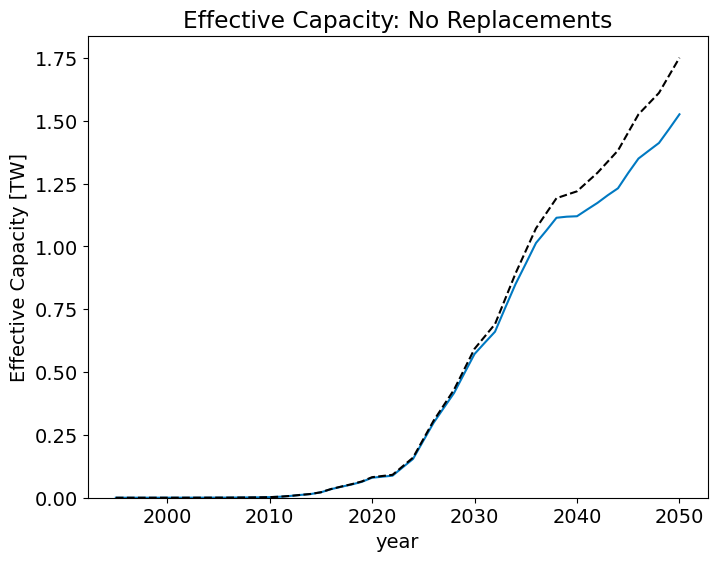

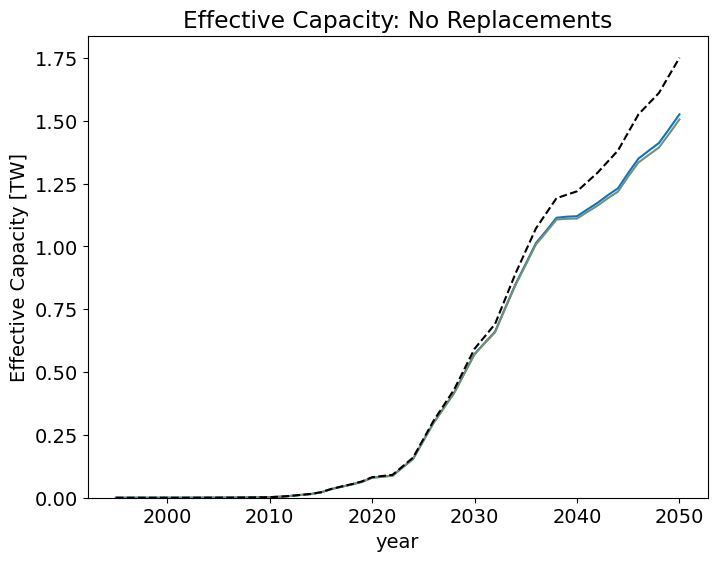

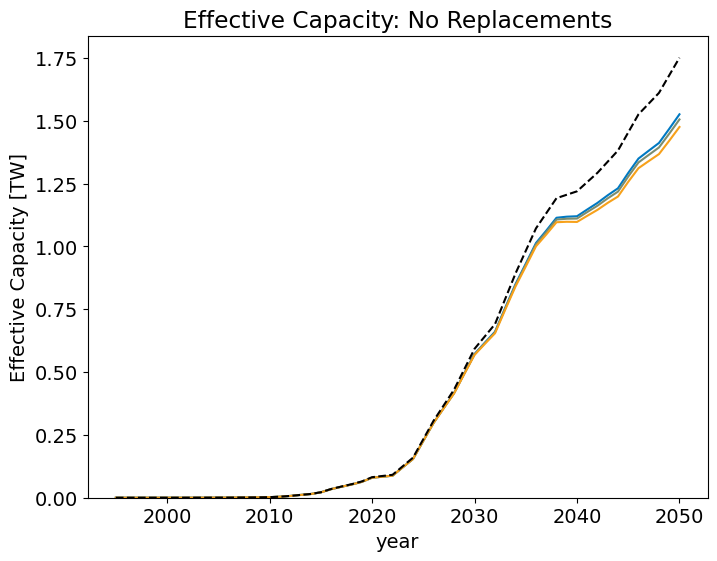

In [38]:
colors = get_color_gradient(color1, color2, len(scennames2)) #generates a list of hex values

effective_capacity_tw = effective_capacity/1e6
for scen in range(0,len(scennames2)):
    effective_capacity_tw.iloc[:,0:scen+1].plot(color=colors, legend=False, title='Effective Capacity: No Replacements')
    plt.plot(installs_cumu/1e6, label='Capacity Target', color='black', ls='--') 
    plt.ylim(0,)
    plt.ylabel('Effective Capacity [TW]')
    plt.savefig(os.path.join(testfolder, 'deg'+str(scen)))
    
#plt.title('Effective Capacity: No Replacements')

# Replacements

In [39]:
for row in range (0,len(sim2.scenario['deg_0.95%/yr'].dataIn_m)): #loop over length of years
    for scen in scennames2: #loop over scenarios
        Under_Installment = installs_cumu.iloc[row] - ((sim2.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
        sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        #calculate flows for that scenario with it's bifi factor and modified weibull
        sim2.calculateFlows(scenarios=[scen], nameplatedeglimit=0.8) # , bifacialityfactors=bifiPathDict[scen]

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
Finished Area+Power Generation Calculations


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.7%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.8%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_12264\329027222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim2.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  deg_0.95%/yr
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


In [40]:
sim2_cc_yearly, sim2_cc_cumu = sim2.aggregateResults() #have to do this to get auto plots
sim2_allenergy, sim2_energyGen, sim2_energy_demands = sim2.aggregateEnergyResults()

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)


(0.0, 1838649.4790407978)

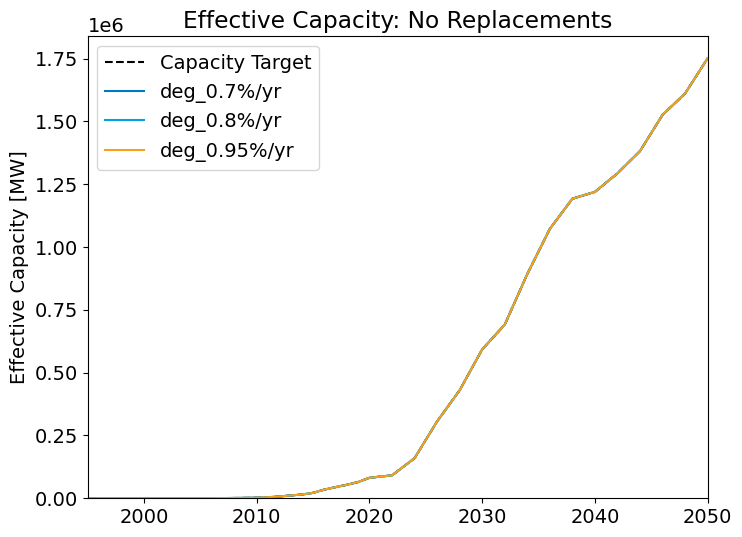

In [41]:
effective_capacity = sim2_cc_yearly.filter(like='ActiveCapacity')
plt.plot(installs_cumu, label='Capacity Target', color='black', ls='--')
    
plt.plot(effective_capacity, label=scennames2)
plt.legend()
plt.ylabel('Effective Capacity [MW]')
plt.title('Effective Capacity: No Replacements')
plt.xlim(1995,2050)
plt.ylim(0,)

(1.4, 2.2)

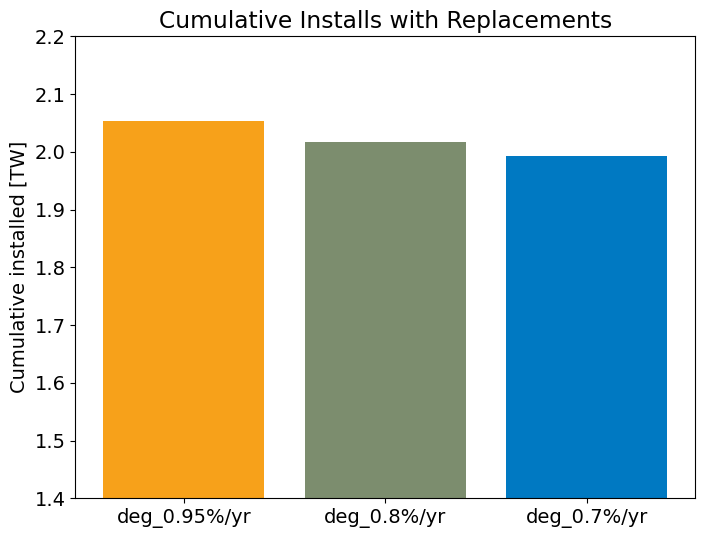

In [47]:
cumu_installs = sim2_cc_cumu.filter(like='newInstalled')
plt.bar(scennames2[::-1], cumu_installs.loc[2050,::-1]/1e6, color=colors[::-1])
#plt.legend(scennames)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.ylim(1.4,2.2)
#plt.xticks(rotation=90)

In [43]:
cumu_installs

,newInstalledCapacity_sim1_deg_deg_0.7%/yr_[MW],newInstalledCapacity_sim1_deg_deg_0.8%/yr_[MW],newInstalledCapacity_sim1_deg_deg_0.95%/yr_[MW]
year,,,
1995,1.250000e+01,1.250000e+01,1.250000e+01
1996,2.226146e+01,2.226146e+01,2.226146e+01
1997,3.405059e+01,3.405059e+01,3.405059e+01
1998,4.609002e+01,4.609002e+01,4.609002e+01
1999,6.333315e+01,6.333315e+01,6.333315e+01
2000,8.476936e+01,8.476936e+01,8.476936e+01
2001,1.134640e+02,1.134640e+02,1.134640e+02
2002,1.569280e+02,1.569280e+02,1.569280e+02
2003,2.180800e+02,2.180800e+02,2.180800e+02


In [44]:
(cumu_installs.loc[2050,'newInstalledCapacity_sim1_deg_deg_0.95%/yr_[MW]']-
 cumu_installs.loc[2050,'newInstalledCapacity_sim1_deg_deg_0.7%/yr_[MW]'])

60027.08697411441